# **Setup & Imports**

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from abc import ABC, abstractmethod
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import datetime

# Widgets and file upload
from google.colab import files
import ipywidgets as widgets
from IPython.display import display


# **Base Class (MLTask)**

In [2]:
# Abstract base class for all ML pipeline components
# Forces all derived classes to implement a `.run()` method
class MLTask(ABC):
    @abstractmethod
    def run(self):
        pass

# **DataProcessor Class**

In [3]:
# Handles dataset loading and preprocessing
class DataProcessor(MLTask):
    def __init__(self, df=None, target_column=None, scale_data=True):
        self.df = df
        self.target_column = target_column
        self.scale_data = scale_data
        self.X = None
        self.y = None

    def run(self):
        if self.df is None:
            # Load default Iris dataset if no CSV provided
            print("Loading Iris dataset...")
            iris = load_iris(as_frame=True)
            df = iris.frame
            X = df.drop(columns=['target'])
            y = df['target']
        else:
            print("Using uploaded dataset...")
            df = self.df.dropna()
            X = df.drop(columns=[self.target_column])
            y = df[self.target_column]

        if self.scale_data:
            print("Scaling data...")
            scaler = StandardScaler()
            X = scaler.fit_transform(X)

        self.X = X
        self.y = y
        print("Data prepared.\n")
        return self.X, self.y

# **ModelTrainer Class**

In [4]:
# Trains the machine learning model and saves it automatically with timestamp
class ModelTrainer(MLTask):
    def __init__(self, model, X_train, y_train):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.trained_model = None

    def run(self):
        print(f"Training model: {type(self.model).__name__}")
        start_time = time.time()

        # Train the model
        self.model.fit(self.X_train, self.y_train)

        elapsed = time.time() - start_time
        print(f"Training completed in {elapsed:.2f} seconds.\n")

        self.trained_model = self.model

        # Auto-generate filename with timestamp
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        filename = f"trained_model_{timestamp}.pkl"

        # Save model
        joblib.dump(self.trained_model, filename)
        print(f"Model saved as '{filename}'")

        return self.trained_model

# **Evaluator Class**

In [5]:
# Evaluates the trained model using standard metrics
class Evaluator(MLTask):
    def __init__(self, model, X_test, y_test, average='macro', show_confusion=True):
        self.model = model
        self.X_test = X_test
        self.y_test = y_test
        self.average = average
        self.show_confusion = show_confusion

    def run(self):
        print("Evaluating model...")
        y_pred = self.model.predict(self.X_test)

        acc = accuracy_score(self.y_test, y_pred)
        prec = precision_score(self.y_test, y_pred, average=self.average)
        rec = recall_score(self.y_test, y_pred, average=self.average)
        f1 = f1_score(self.y_test, y_pred, average=self.average)

        print(f"Accuracy:  {acc:.4f}")
        print(f"Precision: {prec:.4f}")
        print(f"Recall:    {rec:.4f}")
        print(f"F1 Score:  {f1:.4f}")

        # Plot bar chart of evaluation metrics
        metrics = [acc, prec, rec, f1]
        labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']

        plt.figure(figsize=(8, 4))
        plt.bar(labels, metrics, color='skyblue')
        plt.ylim(0, 1.1)
        plt.title("Model Evaluation Metrics")
        plt.ylabel("Score")
        plt.show()

        # Plot confusion matrix
        if self.show_confusion:
            cm = confusion_matrix(self.y_test, y_pred)
            plt.figure(figsize=(5, 4))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title("Confusion Matrix")
            plt.xlabel("Predicted")
            plt.ylabel("Actual")
            plt.show()

        print("Evaluation complete.\n")
        return {
            'accuracy': acc,
            'precision': prec,
            'recall': rec,
            'f1_score': f1
        }

# **MLPipelineManager Class**

In [6]:
# Manages the full ML pipeline process
class MLPipelineManager:
    def __init__(self, model, df=None, target_column=None):
        self.model = model
        self.df = df
        self.target_column = target_column
        self.metrics = None

    def run(self):
        print("Starting ML Pipeline...\n")
        processor = DataProcessor(df=self.df, target_column=self.target_column)
        X, y = processor.run()

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        print("Data split into training and test sets.\n")

        trainer = ModelTrainer(self.model, X_train, y_train)
        model = trainer.run()

        evaluator = Evaluator(model, X_test, y_test)
        self.metrics = evaluator.run()
        return self.metrics

# **Program Class (Main Controller)**

In [7]:
# Main controller to manage the ML process interactively in Google Colab
class Program:
    def __init__(self):
        self.uploaded_df = None
        self.target_column_selector = None
        self.model_selector = None
        self.model_map = {}

    def upload_file(self):
        print("Please upload a CSV file.")
        uploaded = files.upload()
        for fn in uploaded.keys():
            if fn.endswith('.csv'):
                df = pd.read_csv(fn)
                if df.shape[1] < 2:
                    print("File must contain at least 2 columns.")
                    return None
                else:
                    print(f"File '{fn}' uploaded successfully.")
                    return df
            else:
                print("Invalid file format. Only CSV is supported.")
                return None

    def select_target_column(self, df):
        dropdown = widgets.Dropdown(options=list(df.columns), description='Target Column:')
        display(dropdown)
        return dropdown

    def select_model(self):
        options = {
            'KNN': KNeighborsClassifier(),
            'Decision Tree': DecisionTreeClassifier(),
            'SVM': SVC()
        }
        dropdown = widgets.Dropdown(options=list(options.keys()), description='Model:')
        display(dropdown)
        return dropdown, options

    def run(self):
        # Step 1: Upload dataset
        df = self.upload_file()
        if df is not None:
            self.uploaded_df = df
            self.target_column_selector = self.select_target_column(df)
        else:
            print("Using default Iris dataset as fallback.")
            self.uploaded_df = None

        # Step 2: Select model
        self.model_selector, self.model_map = self.select_model()

        # Step 3: Display button to trigger pipeline
        run_button = widgets.Button(description="Run ML Pipeline", button_style='success')
        run_button.on_click(self._on_run_clicked)
        display(run_button)

    def _on_run_clicked(self, b):
        self.run_pipeline()

    def run_pipeline(self):
        # Get selected model and target column
        target_col = self.target_column_selector.value if self.uploaded_df is not None else None
        selected_model = self.model_map[self.model_selector.value]

        # Run pipeline
        pipeline = MLPipelineManager(model=selected_model, df=self.uploaded_df, target_column=target_col)
        metrics = pipeline.run()

        # Show final metrics in the output
        print("Final Evaluation Results:")
        for key, value in metrics.items():
            print(f"{key.capitalize()}: {value:.4f}")

# **Run**

Please upload a CSV file.


Saving breast_cancer_full.csv to breast_cancer_full.csv
File 'breast_cancer_full.csv' uploaded successfully.


Dropdown(description='Target Column:', options=('mean radius', 'mean texture', 'mean perimeter', 'mean area', …

Dropdown(description='Model:', options=('KNN', 'Decision Tree', 'SVM'), value='KNN')

Button(button_style='success', description='Run ML Pipeline', style=ButtonStyle())

Starting ML Pipeline...

Using uploaded dataset...
Scaling data...
Data prepared.

Data split into training and test sets.

Training model: SVC
Training completed in 0.00 seconds.

Model saved as 'trained_model_2025-05-17_09-36-01.pkl'
Evaluating model...
Accuracy:  0.9708
Precision: 0.9672
Recall:    0.9702
F1 Score:  0.9687


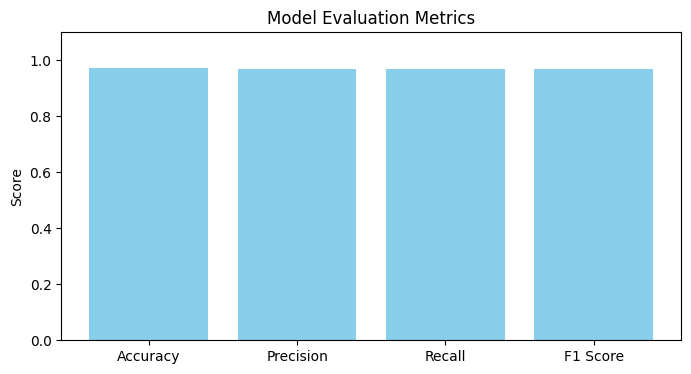

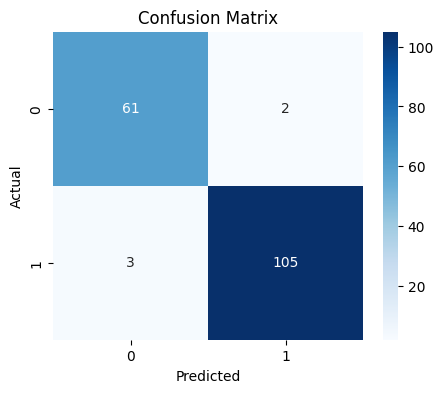

Evaluation complete.

Final Evaluation Results:
Accuracy: 0.9708
Precision: 0.9672
Recall: 0.9702
F1_score: 0.9687


In [9]:
app = Program()
app.run()